# FACE RECOGNITION USING MOBILENET

### Loading the MobileNet Model

In [ ]:
from keras.applications import MobileNet

#loads mobileNet's archetecture and weight
MobileNet = MobileNet(weights = 'imagenet', include_top = False, input_shape = (224,224, 3))

# Here we freeze the layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False

### Let's make a function that returns our FC Head

In [ ]:
def newLayers(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

### Let's add our FC Head back onto MobileNet

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# number of classes to recognize
num_classes = 3

#attaching new set of layers
FC_Head = newLayers(MobileNet, num_classes)

#merging the layers to form one architecture
model = Model(inputs = MobileNet.input, outputs = FC_Head)

### Loading Dataset

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'images/tain/'
validation_data_dir = 'images/test/'

img_cols, img_rows = 224, 224

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

### Training out Model
- Note we're using checkpointing and early stopping

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("myRecog.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1097
nb_validation_samples = 272

# We only train 5 EPOCHS 
epochs = 5
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

### Loading our classifer


In [1]:
from keras.models import load_model

#loading trained model
model = load_model('myRecog.h5')

Using TensorFlow backend.


### Testing our model

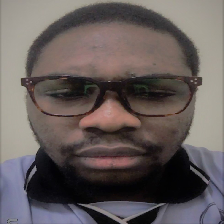

In [2]:
from keras.preprocessing import image
import numpy as np
#categories
category_dict= { 0 : "Mishan", 
                 1 : "Siam ",
                 2 : "Yobah"
               }

#loading image
img = image.load_img('images/checker/539.jpg', target_size=(224,224))
img

In [3]:
img = np.expand_dims(img, axis = 0) #expands the dimention of the image


In [4]:
pred = model.predict(img) #predicts 

In [5]:
#prints the percentages of certainty
print("+----------------+")
j = 0
for layer in pred:
    for percentage in layer:
        print("|"+ category_dict[j] + "-- " + " %5.2f" % (percentage*100) + "%")
        j+=1
print("+----------------+")

+----------------+
|Mishan--   9.29%
|Siam --   0.11%
|Yobah--  90.60%
+----------------+
